In [1]:
import pandas as pd
import numpy as np
import math
from scipy.stats import trim_mean


df = pd.read_csv("/kaggle/input/mpg-data/mpg_veri.csv")
k=7
_horsepower=130
_weight=3500
_acceleration=13
pointt = [_horsepower, _weight, _acceleration]

In [2]:
def Find_missing_rows(data, desired_columns):
    
    missing_values = data[data[desired_columns].isna().any(axis=1)]
    return missing_values


#işlem yapılcak boş değer var mı diye sütunları yazdık
search_columns = ["horsepower", "weight","acceleration","mpg"]

#eksik değer içern satıları yazdık
print( Find_missing_rows(df, search_columns))

      mpg  cylinders  displacement  horsepower  weight  acceleration  \
32   25.0          4          98.0         NaN    2046          19.0   
126  21.0          6         200.0         NaN    2875          17.0   
330  40.9          4          85.0         NaN    1835          17.3   
336  23.6          4         140.0         NaN    2905          14.3   
354  34.5          4         100.0         NaN    2320          15.8   
374  23.0          4         151.0         NaN    3035          20.5   

     model_year  origin                  name  
32           71     usa            ford pinto  
126          74     usa         ford maverick  
330          80  europe  renault lecar deluxe  
336          80     usa    ford mustang cobra  
354          81  europe           renault 18i  
374          82     usa        amc concord dl  


In [3]:
#boş değerleri silmek yerine trim mean ile doldurduk
def fillna_with_trimmean(df, istenen_sutunlar, proportiontocut=0.1, decimal_places=2):

    df_copy=df.copy()
    
    for column in istenen_sutunlar:
        trimmean_result = round(trim_mean(df_copy[column], proportiontocut=proportiontocut), decimal_places)
        
        # NaN veya 0 olan değerleri trimmean değeri ile doldur
        df_copy[column] = df_copy[column].replace({0: trimmean_result}).fillna(trimmean_result)
    
    return df_copy

df_filled = fillna_with_trimmean(df, search_columns)
print(df.iloc[30:34, :])
print(df_filled.iloc[30:34, :])

     mpg  cylinders  displacement  horsepower  weight  acceleration  \
30  28.0          4         140.0        90.0    2264          15.5   
31  25.0          4         113.0        95.0    2228          14.0   
32  25.0          4          98.0         NaN    2046          19.0   
33  19.0          6         232.0       100.0    2634          13.0   

    model_year origin                 name  
30          71    usa  chevrolet vega 2300  
31          71  japan        toyota corona  
32          71    usa           ford pinto  
33          71    usa          amc gremlin  
     mpg  cylinders  displacement  horsepower  weight  acceleration  \
30  28.0          4         140.0       90.00    2264          15.5   
31  25.0          4         113.0       95.00    2228          14.0   
32  25.0          4          98.0      101.01    2046          19.0   
33  19.0          6         232.0      100.00    2634          13.0   

    model_year origin                 name  
30          71    

In [4]:
def Euclidean_distance(point1, point2):
    #return math.sqrt(sum((x - y) ** 2 for x, y in zip(point1, point2)))
    return math.sqrt(sum((point1[i] - point2[i]) ** 2 for i in range(len(point1))))


In [5]:
X_train = df_filled[["horsepower", "weight", "acceleration"]]  # X_train
y = df_filled['mpg']  # Hedef değişken (etiketler)


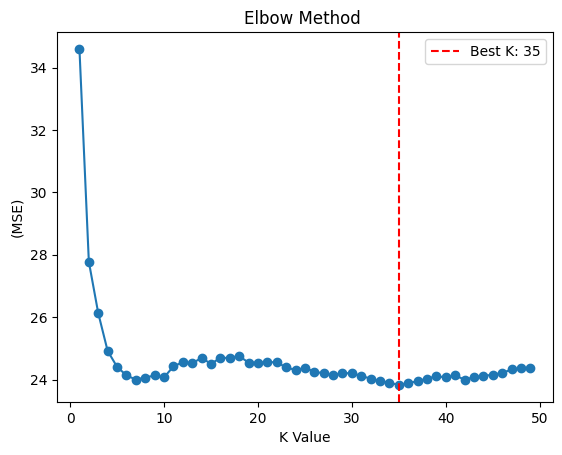

Best K value: 35


In [6]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor


# K değerlerini belirle
k_values = list(range(1, 50))

# Çapraz doğrulama ile hata hesapla
cv_errors = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    errors = -cross_val_score(knn, X_train, y, cv=5, scoring='neg_mean_squared_error')
    cv_errors.append(errors.mean())

# Elbow Method ile en iyi k değerini bul
best_k = k_values[cv_errors.index(min(cv_errors))]

# Grafik çizimi
plt.plot(k_values, cv_errors, marker='o')
plt.xlabel('K Value')
plt.ylabel('(MSE)')
plt.title('Elbow Method ')
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best K: {best_k}')
plt.legend()
plt.show()

print(f'Best K value: {best_k}')


In [7]:
def SortedDistancewIndex(point, X_train):
    distances = []
    for index, row in X_train.iterrows():
        distance = Euclidean_distance(point, np.array(row))
        distances.append((distance,index))

    sorted_distances = sorted(distances, key=lambda x: x[0])
    
    return sorted_distances


In [8]:

def Weighted_knn_predict(point, X_train, y_train, k):

    
    sorted_distances_indices = SortedDistancewIndex(pointt,X_train)
    # İlk k komşuyu seç
    k_neighbors = sorted_distances_indices[:k]
    
    # Ağırlıklı tahmin yap
    weighted_sum = 0
    total_weight = 0
    
    for distance, index in k_neighbors:
        weight = 1 / distance  # Mesafeye göre ağırlık
        weighted_sum += weight * y_train.loc[index]
        total_weight += weight
    
    if total_weight == 0:
        return 0  # Bölme sıfıra bölme hatasını önlemek için kontrol
    else:
        return weighted_sum / total_weight


In [9]:
predicted_value = Weighted_knn_predict(pointt, X_train, y, best_k)
print("Weighted KNN Predict with Trimmean and best K value:", predicted_value)

Weighted KNN Predict with Trimmean and best K value: 18.28733723887729


In [10]:
selected_columns = ["horsepower", "weight", "acceleration","mpg"]

df_dropped = df.dropna(subset=selected_columns)

X_trainwht = df_dropped[["horsepower", "weight", "acceleration"]]  # X_train
ywht= df_dropped['mpg'] 
predicted_value = Weighted_knn_predict(pointt, X_trainwht, ywht, best_k)
print("Weighted KNN Predict with Dropped and best K value:", predicted_value)

Weighted KNN Predict with Dropped and best K value: 18.28733723887729


In [11]:
predicted_value = Weighted_knn_predict(pointt, X_train, y, k)
print("Weighted KNN Predict with Trimmean:", predicted_value)

Weighted KNN Predict with Trimmean: 18.21703986750805


In [12]:
selected_columns = ["horsepower", "weight", "acceleration","mpg"]

df_dropped = df.dropna(subset=selected_columns)

X_trainwht = df_dropped[["horsepower", "weight", "acceleration"]]  # X_train
ywht= df_dropped['mpg'] 
predicted_value = Weighted_knn_predict(pointt, X_trainwht, ywht, k)
print("Weighted KNN Predict with Dropped:", predicted_value)

Weighted KNN Predict with Dropped: 18.21703986750805


In [13]:
#Bu veri seti için kırpılmış ortalama kullanmak yerine verileri silmek az da olsa avantaj sağğlar gibi gözüküyor
#Çünkü istenilen örneğin sonucunda neredeyse değişiklik yoktur belki de kırpılmış ortalamayı alırken 0.1 yerine 0.2 alsak ortalama değişebilir
#Hatta en iyi k değerini hesaplamaya bile gerek olmayabilir aradaki fark 0.7lık bir sapma veriyor bize bu da büyük bir etki yaratcağını sanmıyorum